# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%cd "/content/drive/MyDrive/CI/"
!pip install import-ipynb

In [ ]:
import import_ipynb
import utility
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ', device_name)

# Preprocessing

## Dataset Loading

In [ ]:
images, labels = utility.load_training()

train_abnormal_images, train_abnormal_labels = utility.benignant_malignant_training_set_building(images, labels)

In [ ]:
train_samples, train_labels = utility.oversample(train_abnormal_images, train_abnormal_labels)

print(np.shape(train_samples))

In [ ]:
test_images, test_labels = utility.load_test()

test_abnormal_imgs, test_abnormal_labels = utility.benignant_malignant_test_set_building(test_images, test_labels)


## Images Preparation

In [ ]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

NORMALIZATION_VALUE = 65536

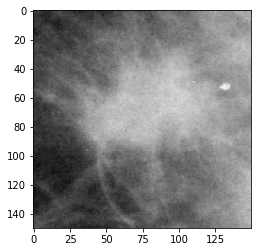

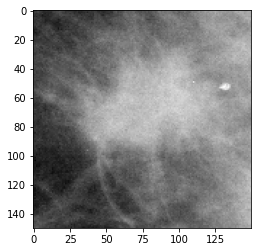

In [ ]:
#CONTRAST ADJUSTMENT

plt.imshow(train_samples[0], cmap='gray')
plt.show()

train_samples_adjusted = utility.apply_contrast(train_samples, contrast=1.5)

plt.imshow(train_samples_adjusted[0], cmap='gray')
plt.show()

test_samples_adjusted = utility.apply_contrast(test_abnormal_imgs, contrast=1.5)

### Generators

In [ ]:
train_samples_reshaped = np.expand_dims(train_samples_adjusted,3)

test_samples_reshaped = np.expand_dims(test_samples_adjusted,3)

print(np.shape(train_samples_reshaped))
print(np.shape(train_labels))

val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_samples_reshaped, train_labels, test_size=val_split, stratify=train_labels) #shuffle = True (default)

datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)

train_generator = datagen.flow(X_train, 
                                     y=y_train, 
                                     batch_size=BATCH_SIZE)
print('Train Generator created')
validation_generator = datagen.flow(X_val, 
                                     y=y_val, 
                                     batch_size=BATCH_SIZE)       
print('Validation Generator created')
           
test_datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)


test_generator =  datagen.flow(test_samples_reshaped,
                                y=test_abnormal_labels,
                                batch_size=BATCH_SIZE)

print('Test Generator created')

(3136, 150, 150, 1)
(3136,)
Train Generator created
Validation Generator created
Test Generator created


## Network Building

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))
conv_base.trainable = False
print('InceptionV3 loaded and set untrainable')
#conv_base.summary()

conv_base_last = Model(inputs=conv_base.input, outputs=conv_base.get_layer('mixed8').output)
conv_base_last.summary()

In [ ]:
from tensorflow.keras import models, layers, regularizers

model_iv3 = models.Sequential(name="Pre_trained_iv3")
model_iv3.add(tf.keras.Input(shape=(150,150,1)))
model_iv3.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123)) #paper 
model_iv3.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest')) #90degree
model_iv3.add(layers.Conv2D(3, (1, 1), activation='relu'))
model_iv3.add(conv_base_last)
model_iv3.add(layers.Flatten())
model_iv3.add(layers.Dense(512, activation='relu'))
model_iv3.add(layers.Dense(256, activation='relu'))
model_iv3.add(layers.Dense(1, activation='sigmoid'))

model_iv3.summary()

In [ ]:
model_iv3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

EPOCHS = 20

In [ ]:
history = model_iv3.fit(train_generator,
          validation_data=validation_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

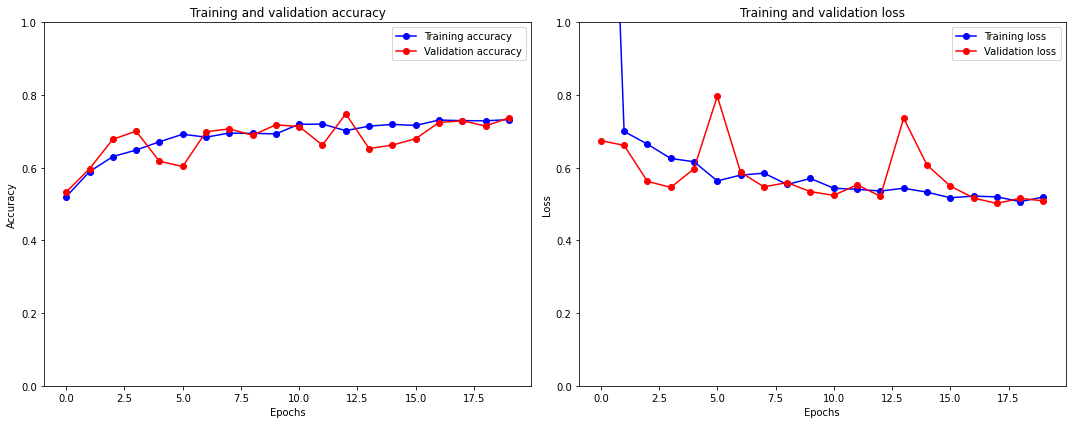

In [ ]:
utility.plot_history(history,'BMINCEPTIONBEST')

In [ ]:
dir_name ="/content/drive/MyDrive/CI/models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model_iv3.save(os.path.join(dir_name,'bm_inception_best.h5'))

In [ ]:
test_loss, test_accuracy = model_iv3.evaluate(test_generator)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

In [ ]:
normalized_test_samples_reshaped = test_samples_reshaped/NORMALIZATION_VALUE
test_predictions = model_iv3.predict(normalized_test_samples_reshaped)

utility.do_evaluations(test_predictions, test_abnormal_labels)

## Conv 2D vs Replication

In [ ]:
images, labels = utility.load_training()

train_abnormal_images, train_abnormal_labels = utility.benignant_malignant_training_set_building(images, labels)

train_samples, train_labels = utility.oversample(train_abnormal_images, train_abnormal_labels)


test_images, test_labels = utility.load_test()

test_abnormal_imgs, test_abnormal_labels = utility.benignant_malignant_test_set_building(test_images, test_labels)

print('Labels loaded')

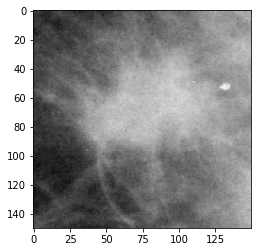

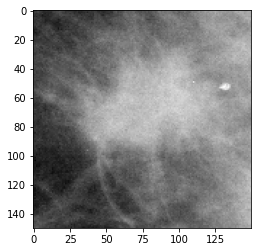

Contrast adjusted


In [ ]:
plt.imshow(train_samples[0], cmap='gray')
plt.show()

train_samples_adjusted = utility.apply_contrast(train_samples, contrast=1.5)

plt.imshow(train_samples_adjusted[0], cmap='gray')
plt.show()

test_samples_adjusted = utility.apply_contrast(test_abnormal_imgs, contrast=1.5)

print('Contrast adjusted')

In [ ]:
train_3channel_images = []
for img in train_samples_adjusted:
  train_3channel_images.append(np.stack((img,)*3, axis=-1))

test_3channel_images = []
for img in test_samples_adjusted:
  test_3channel_images.append(np.stack((img,)*3, axis=-1))

train_3channel_images = np.array(train_3channel_images)
test_3channel_images = np.array(test_3channel_images)

print(np.shape(train_samples_adjusted))
print(np.shape(train_3channel_images))


(3136, 150, 150)
(3136, 150, 150, 3)


In [ ]:
val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(train_3channel_images, train_labels, test_size=val_split, stratify=train_labels) #shuffle = True (default)

datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)

train_generator = datagen.flow(X_train, 
                                     y=y_train, 
                                     batch_size=BATCH_SIZE)
print('Train Generator created')
validation_generator = datagen.flow(X_val, 
                                     y=y_val, 
                                     batch_size=BATCH_SIZE)       
print('Validation Generator created')
           
test_datagen = ImageDataGenerator(rescale=1./NORMALIZATION_VALUE)


test_generator =  datagen.flow(test_3channel_images,
                                y=test_abnormal_labels,
                                batch_size=BATCH_SIZE)

print('Test Generator created')

Train Generator created
Validation Generator created
Test Generator created


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))
conv_base.trainable = False
print('InceptionV3 loaded and set untrainable')
#conv_base.summary()

conv_base_last = Model(inputs=conv_base.input, outputs=conv_base.get_layer('mixed8').output)
#conv_base_last.summary()

In [ ]:
from tensorflow.keras import models, layers, regularizers

model_iv3 = models.Sequential(name="Pre_trained_Replication")
model_iv3.add(tf.keras.Input(shape=(150,150,3)))
model_iv3.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123)) #paper 
model_iv3.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest')) #90degree
#model_iv3.add(layers.Conv2D(3, (1, 1), activation='relu'))
model_iv3.add(conv_base_last)
model_iv3.add(layers.Flatten())
model_iv3.add(layers.Dense(512, activation='relu'))
model_iv3.add(layers.Dense(256, activation='relu'))
model_iv3.add(layers.Dense(1, activation='sigmoid'))

model_iv3.summary()

In [ ]:
model_iv3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

EPOCHS = 20

In [ ]:
history = model_iv3.fit(train_generator,
          validation_data=validation_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS)

In [ ]:
utility.plot_history(history)

In [ ]:
test_loss, test_accuracy = model_iv3.evaluate(test_generator)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

In [ ]:
normalized_test_samples_reshaped = test_3channel_images/NORMALIZATION_VALUE
test_predictions = model_iv3.predict(normalized_test_samples_reshaped)

utility.do_evaluations(test_predictions, test_abnormal_labels)